In [2]:
import numpy as np
import matplotlib.pyplot as plt

class NoisyLIFNeuron:
    def __init__(self, tau, R, threshold, sigma, dt=0.01):
        self.tau = tau  # Membrane time constant
        self.R = R      # Membrane resistance
        self.threshold = threshold  # Firing threshold
        self.sigma = sigma #Amplitude of the noise (in units of voltage)
        self.dt = dt    # Time step
        self.reset()

    def reset(self):
        self.voltage = 0.0  # Initial membrane potential

    def update(self, I):
        # Membrane potential update using Euler method
        dv = (-(self.voltage) + self.R * I) / self.tau * self.dt + self.sigma*np.sqrt(self.dt)*np.random.normal(0, 1)
        self.voltage += dv
        # Check for spike
        if self.voltage >= self.threshold:
            self.voltage = 0.0  # Reset membrane potential after spike
            return True
        else:
            return False

def simulate_neuron(I, tau, R, threshold, sigma, dt=0.01, duration=10):
    neuron = NoisyLIFNeuron(tau, R, threshold, sigma, dt)
    time = np.arange(0, duration, dt)
    spikes = []
    voltages = []
    for t in time:
        spike = neuron.update(I)
        voltages.append(neuron.voltage)
        if spike:
            spikes.append(t)
    return spikes, voltages


[1.2100e+01 1.0870e+02 1.6344e+02 2.0398e+02 2.3360e+02 3.9472e+02
 9.5300e+01 1.6736e+02 1.9083e+02 4.7254e+02 4.8216e+02 5.0784e+02
 5.2416e+02 5.3197e+02 9.1680e+01 1.3173e+02 2.1613e+02 1.5310e+02
 1.7314e+02 2.6545e+02 2.7946e+02 2.9232e+02 3.3749e+02 5.9966e+02
 9.7000e-01 1.9363e+02 2.0251e+02 3.7097e+02 4.1629e+02 5.9608e+02
 2.1193e+02 2.5100e+02 2.5281e+02 2.6772e+02 2.4159e+02 3.5816e+02
 4.3650e+02 5.2154e+02 5.9105e+02 2.3222e+02 3.7370e+02 4.1990e+01
 1.1584e+02 1.4660e+02 1.7214e+02 2.0475e+02 2.8836e+02 3.0425e+02
 3.1701e+02 3.4452e+02 3.4569e+02 3.6290e+02 3.7320e+02 3.8914e+02
 3.9332e+02 4.8975e+02 5.3437e+02 1.4002e+02 3.6346e+02 4.9061e+02
 4.9389e+02 4.5810e+01 2.6606e+02 5.2185e+02 6.0480e+01 3.3659e+02
 5.0122e+02 5.1501e+02 5.9546e+02 5.9914e+02 2.4390e+01 3.0976e+02
 3.8085e+02 4.5508e+02 1.2430e+02 1.2828e+02 1.9940e+02 5.2329e+02
 5.7940e+02 5.7943e+02 5.9280e+02 3.2310e+01 1.6940e+01 1.7316e+02
 3.5371e+02 3.6887e+02 1.5010e+02 1.5378e+02 3.7975e+02 3.8172

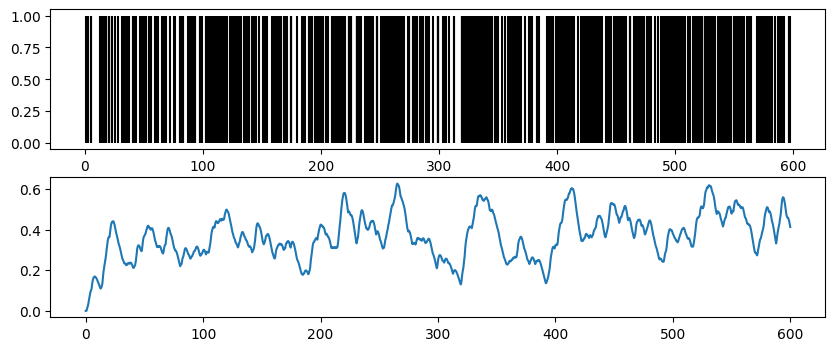

In [12]:
# Simulation parameters
tau = 4 # Membrane time constant (ms)
R = 1    # Membrane resistance
threshold = float('inf')  # Firing threshold
sigma = 0  #NO STOCHASTIC NOISE

dt = 0.01 # Time step (ms)
duration = 600  # Duration of simulation (ms)
t=np.arange(0, duration, dt)

I = 0  # Input current (arbitrary units)

lamda_hz = 10  # Rate of the Poisson process (in Hz)
lambda_ = lamda_hz/1e3  # Rate of the Poisson process (events per unit time (spikes/ms))

w = 0.1 #synaptic weight

def background(dt, t, N_background):
    bg = 0
    spikes_bg = []
    for j in range(N_background):
        # Generate Poisson process
        events = np.random.poisson(lambda_ * dt, len(t))
        events[events > 1] = 1  # Ensure at most one event per timestep

        #obtain spike times
        spikes_temp = events*t
        spike_times = spikes_temp[spikes_temp != 0]
        spikes_bg = np.concatenate((spikes_bg,spike_times))
        #presinaptic input
        epsilon=0
        for i in range(len(spike_times)):
            bg = bg + (((t-spike_times[i]))/tau)*np.exp(-(t-spike_times[i])/tau)*np.heaviside(t-spike_times[i],0.5)
    return bg, spikes_bg

print(spikes_bg)
bg, spikes_bg = background(dt,t, 100)
spikes, voltages = simulate_neuron(I, tau, R, threshold, sigma, dt, duration)
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.vlines(spikes_bg, ymin=0, ymax=1, colors='black', linestyles='-')
plt.subplot(2,1,2)
plt.plot(t, voltages+w*bg)
